In [1]:
import pickle
import glob
import json
import time
import pandas as pd
import seaborn as sns
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from matplotlib import rcParams
import matplotlib.pyplot as plt

import os
os.environ['OPENAI_API_KEY'] = 'key'

# Open the manuscript dictionaries to get DOIs

In [2]:
with open('data_input/scipdf.pkl', 'rb') as handle:
    pdf_dict = pickle.load(handle)
    
pdf_doi_dict = {}
for pdf_name in pdf_dict.keys():
    pdf_doi_dict[pdf_name.replace(".pdf", "")] = pdf_dict[pdf_name]["doi"]

# Extract all trait information from the 21 manuscripts

In [ ]:
trait_results = pd.DataFrame()
json_dict = {}
fail_list = []

for key in pdf_dict.keys():
    time.sleep(2)
    embeddings = OpenAIEmbeddings()
    key = key.replace(".pdf", "")
    db = FAISS.load_local("data_faiss/faiss_chunked/faiss_db_1000/{}".format(key), embeddings, allow_dangerous_deserialization=True)
    retriever = db.as_retriever(search_type="similarity_score_threshold",
                                search_kwargs={"score_threshold": 0.5, "k": 25})

    query = """Find and extract all the traits that were measured in the provided genetic mapping manuscript. \
               Traits are defined as measured phenotypes, conditions and environments. \
               If a trait was measured using different methods, include each condition as a separate trait. \
               Only include trait abbreviation if it was used in the text, otherwise return 'None'. \
               Do not include traits that were referenced but not measured in this study. 

               Important - Respond in JSON format only, following the schema below:
                ```json
                {
                   "trait_name": string  // full name of the measured trait, non-abbreviated,
                   "trait_abv": string  // abbreviated trait name, only if provided, otherwise 'None'
                   "trait_description": string // A description of the methods and conditions used to measure the trait
                }```
            """
    
    # Uncommend the LLM model you want to use for the RAG chain
    llm = ChatOpenAI(model_name='gpt-3.5-turbo-1106')
    #llm = ChatOpenAI(model_name='gpt-4') 
    qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
    marker_response = qa(query)

    json_dict[key] = marker_response['result']

    try:
        response_string = marker_response['result']
        response_string = response_string.split("```")[1] if "```" in response_string else response_string
        response_string = response_string.replace("```", "")
        response_string = response_string.replace("json\n", "")
        response_string = response_string.replace("}\n{", "},\n{")
        response_string = response_string.replace("\n}\n}\n", "\n}\n")
        response_string = response_string.replace("}\n", "}")

        if "[" not in response_string:
            response_string = "[" + response_string
        if "]" not in response_string:
            response_string = response_string + "]"

        # Parse the JSON format and turn it into a pandas dataframe
        response_json = json.loads(response_string)
        tmp_df = pd.DataFrame(response_json)

        # Add the PDF and DOI IDs so it is easier to keep track of
        tmp_df["pdf"] = key
        tmp_df["doi"] = pdf_doi_dict[key]
        tmp_df["k"] = 25
        tmp_df["size"] = 1000
        trait_results = pd.concat([trait_results, tmp_df])
        print("success,"+key)
    except:
        print("fail,"+key)
        fail_list.append([key, marker_response['result']])
trait_results.to_csv("data_output/traits/all_manuscripts_size250-1000_25_gpt3.tsv", sep="\t", index=None)

# Make figures for all 21 papers

In [3]:
true_traits = pd.read_csv("data_input/curated_unique_traits.tsv", sep="\t")
true_traits = true_traits.groupby("doi").count().reset_index()[["doi", "trait"]]

pred_traits = pd.read_csv("data_output/traits/all_manuscripts_size250-1000_25_gpt4.tsv", sep="\t")
tmp_gpt4 = pred_traits.groupby("doi").sum().reset_index()[["doi", "correct"]]
tmp_gpt4 = tmp_gpt4.merge(true_traits, on="doi", how="left")
tmp_gpt4["Model"] = "GPT4"

true_traits = pd.read_csv("data_input/curated_unique_traits.tsv", sep="\t")
true_traits = true_traits.groupby("doi").count().reset_index()[["doi", "trait"]]

pred_traits = pd.read_csv("data_output/traits/all_manuscripts_size250-1000_25_gpt3.5.tsv", sep="\t")
tmp_gpt3 = pred_traits.groupby("doi").sum().reset_index()[["doi", "correct"]]
tmp_gpt3 = tmp_gpt3.merge(true_traits, on="doi", how="left")
tmp_gpt3["Model"] = "GPT3.5"

results = pd.concat([tmp_gpt3, tmp_gpt4])
results['% correct'] = results["correct"] / results["trait"] * 100

<Axes: xlabel='Model', ylabel='% correct'>

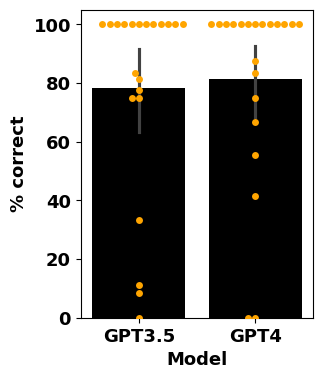

In [4]:
plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(3, 4))

sns.barplot(data=results, x="Model", y= "% correct", color="black")
sns.swarmplot(data=results, x="Model", y= "% correct", color="orange")

# Make Fig. 3G

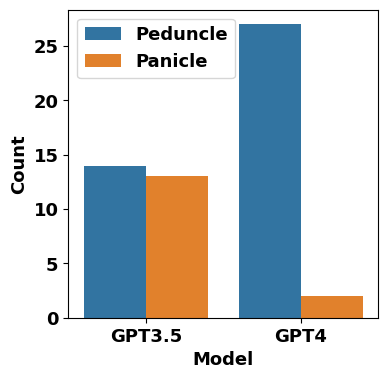

In [5]:
#rcParams['figure.figsize'] = 5, 5
plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(4, 4))


ped_df = [["GPT3.5", "GPT3.5", "GPT4", "GPT4"], 
          ["Peduncle", "Panicle", "Peduncle", "Panicle"],
          [14, 13, 27, 2]]
ped_df = pd.DataFrame(ped_df).T
ped_df.columns = ["Model", "Trait", "Count"]
sns.barplot(ped_df, x="Model", y="Count", hue="Trait")
plt.legend(loc='upper left')

# Analyze a single paper with different chunk sizes and K

In [ ]:
trait_results = pd.DataFrame()
fail_list = []
key = "s00122-014-2435-3.pdf"

for size in [250,500,750,1000]:
    for k in [5,10,15,20,25]:
        for rep in [1,2,3]:
            time.sleep(2)
            embeddings = OpenAIEmbeddings()
            key = key.replace(".pdf", "")
            db = FAISS.load_local("data_faiss/faiss_chunked/faiss_db_{}/{}".format(size, key), embeddings,
                                  allow_dangerous_deserialization=True)
            
            retriever = db.as_retriever(search_type="similarity_score_threshold",
                                        search_kwargs={"score_threshold": 0.5, "k": k})
            
            query = """Find and extract all the traits that were measured in the provided genetic mapping manuscript. \
                       Traits are defined as measured phenotypes, conditions and environments. \
                       If a trait was measured using different methods, include each condition as a separate trait. \
                       Only include trait abbreviation if it was used in the text, otherwise return 'None'. \
                       Do not include traits that were referenced but not measured in this study. 

                       Important - Respond in JSON format only, following the schema below:
                        ```json
                        {
                           "trait_name": string  // full name of the measured trait, non-abbreviated,
                           "trait_abv": string  // abbreviated trait name, only if provided, otherwise 'None'
                           "trait_description": string // A description of the methods and conditions used to measure the trait
                        }```
                    """
            # Uncommend the LLM model you want to use for the RAG chain
            #llm = ChatOpenAI(model_name='gpt-3.5-turbo-1106')
            llm = ChatOpenAI(model_name='gpt-4') 
            qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
            marker_response = qa(query)
            
            # Correct the returned JSON format based on observed errors
            json_dict[key] = marker_response['result']
            try:
                response_string = marker_response['result']
                response_string = response_string.split("```")[1] if "```" in response_string else response_string
                response_string = response_string.replace("```", "")
                response_string = response_string.replace("json\n", "")
                response_string = response_string.replace("}\n{", "},\n{")
                response_string = response_string.replace("\n}\n}\n", "\n}\n")
                response_string = response_string.replace("}\n", "}")
                
                if "[" not in response_string:
                    response_string = "[" + response_string
                if "]" not in response_string:
                    response_string = response_string + "]"
                
                # Parse the JSON format and turn it into a pandas dataframe
                tmp_df = pd.DataFrame(response_json)
                
                tmp_df["pdf"] = key
                tmp_df["doi"] = pdf_doi_dict[key]
                tmp_df["k"] = k
                tmp_df["rep"] = rep
                tmp_df["size"] = size
                trait_results = pd.concat([trait_results, tmp_df])
                print("success,"+key)
            except:
                print("fail,"+key)
                fail_list.append([key, size, k, rep, marker_response['result']])
trait_results.to_csv("data_output/traits/{}-main_size250-1000_5-25_gpt4.tsv".format(key), sep="\t", index=None)

(0.0, 110.0)

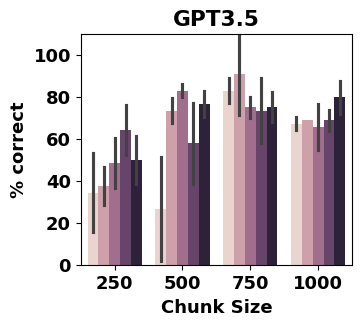

In [8]:
true_traits = 16

plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(3.5, 3))

trait_results = pd.read_csv("data_output/traits/s00122-014-2435-3-main_size250-1000_5-25_gpt3.5.tsv" ,sep="\t")
trait_results = trait_results[trait_results["correct"]==1]
trait_results = trait_results[["k", "rep", "size", "correct"]].groupby(["k", "rep", "size"]).sum().reset_index()
trait_results["correct"] = trait_results["correct"] / true_traits * 100
trait_results.columns = ["K Size", "rep", "Chunk Size", "% correct"]
ax = sns.barplot(data=trait_results, x="Chunk Size", y="% correct", hue="K Size", errorbar="sd")
ax.get_legend().remove()
ax.set_title("GPT3.5")
plt.ylim(0, 110)

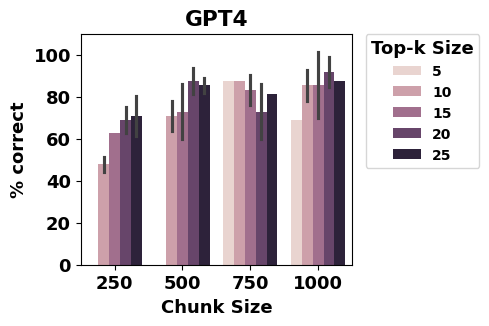

In [7]:
true_traits = 16

plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(3.5, 3))

trait_results = pd.read_csv("data_output/traits/s00122-014-2435-3-main_size250-1000_5-25_gpt4.tsv" ,sep="\t")

trait_results = trait_results[trait_results["correct"]==1]
trait_results = trait_results[["k", "rep", "size", "correct"]].groupby(["k", "rep", "size"]).sum().reset_index()
trait_results["correct"] = trait_results["correct"] / true_traits * 100
trait_results.columns = ["Top-k Size", "rep", "Chunk Size", "% correct"]
ax = sns.barplot(data=trait_results, x="Chunk Size", y="% correct", hue="Top-k Size", errorbar="sd")
ax.set_title("GPT4")
plt.ylim(0, 110)

plt.legend(title="Top-k Size", prop={'size': 10}, # loc='upper left', 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)